In [1]:
!python -m pip install autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requiremen

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from autogluon.tabular import TabularPredictor
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# Load the transaction data
transactions_df = pd.read_csv('/content/drive/MyDrive/Fraud Dataset/updated_fraud_transactions.csv')
transactions_df.head()

,Transaction ID,Timestamp,Sender Account ID,Transaction Type,IN_OUT,Amount,Recipient Bank,Fraud
0,T00001,2023-08-14 08:37:07,10095,Transfer,In,4887.67,B0004,0
1,T00002,2023-12-04 12:54:11,10098,Transfer,In,2371.33,B00010,0
2,T00003,2023-07-09 23:16:11,10097,Credit,In,4733.44,B0008,0
3,T00004,2023-06-26 07:04:39,10039,Credit,In,1544.12,B0005,0
4,T00005,2023-09-28 02:40:56,10018,Debit,Out,3978.04,B0004,0


In [11]:
#load customer data
customers_df = pd.read_csv('/content/drive/MyDrive/Fraud Dataset/customer_dataset 1.csv')
customers_df.head()

,Customer ID,Name,Age,Location,Gender,Account Type,Device Count
0,10001,Nimal Fernando,61,Jaffna,Female,Savings,5
1,10002,Sunil Samarasinghe,60,Jaffna,Other,Current,3
2,10003,Ruwan Jayasinghe,67,Galle,Other,Savings,1
3,10004,Lakshan Perera,19,Anuradhapura,Female,Savings,5
4,10005,Ruwan Kumara,52,Ratnapura,Other,Current,4


Transaction ID       0
Timestamp            0
Sender Account ID    0
Transaction Type     0
IN_OUT               0
Amount               0
Recipient Bank       0
Fraud                0
dtype: int64
Customer ID     0
Name            0
Age             0
Location        0
Gender          0
Account Type    0
Device Count    0
dtype: int64
       Sender Account ID         Amount          Fraud
count      100000.000000  100000.000000  100000.000000
mean        10050.554500    2619.425362       0.048530
std            28.890176    2051.210808       0.214884
min         10001.000000       2.468396       0.000000
25%         10026.000000    1205.750000       0.000000
50%         10051.000000    2481.825000       0.000000
75%         10076.000000    3776.750000       0.000000
max         10100.000000   23017.641096       1.000000
        Customer ID         Age  Device Count
count    100.000000  100.000000    100.000000
mean   10050.500000   51.030000      4.650000
std       29.011492   17.536948

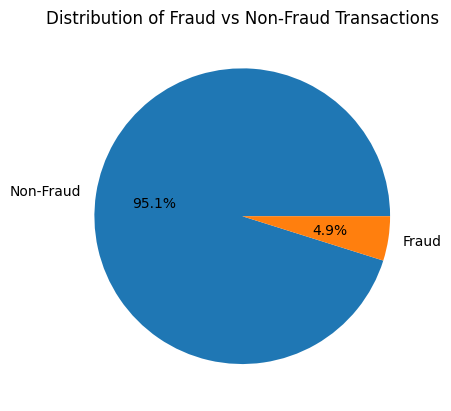

In [12]:

# Check for missing values
print(transactions_df.isnull().sum())
print(customers_df.isnull().sum())

# Display basic statistics
print(transactions_df.describe())
print(customers_df.describe())

# Check the distribution of fraud vs non-fraud transactions
fraud_count = transactions_df['Fraud'].value_counts()
print(fraud_count)
plt.pie(fraud_count, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%')
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.show()

# Convert timestamp to datetime
transactions_df['Timestamp'] = pd.to_datetime(transactions_df['Timestamp'])

# Extract time-based features
transactions_df['Hour'] = transactions_df['Timestamp'].dt.hour
transactions_df['Day'] = transactions_df['Timestamp'].dt.day
transactions_df['Month'] = transactions_df['Timestamp'].dt.month
transactions_df['DayOfWeek'] = transactions_df['Timestamp'].dt.dayofweek

# Encode categorical variables
transactions_df = pd.get_dummies(transactions_df, columns=['Transaction Type', 'IN_OUT', 'Recipient Bank'])
customers_df = pd.get_dummies(customers_df, columns=['Location', 'Gender', 'Account Type'])

In [13]:
# Merge transaction and customer data
merged_df = pd.merge(transactions_df, customers_df, left_on='Sender Account ID', right_on='Customer ID')

# Calculate transaction frequency for each customer
transaction_frequency = merged_df.groupby('Customer ID')['Transaction ID'].count().reset_index()
transaction_frequency.columns = ['Customer ID', 'Transaction_Frequency']
merged_df = pd.merge(merged_df, transaction_frequency, on='Customer ID')

# Calculate average transaction amount for each customer
avg_transaction_amount = merged_df.groupby('Customer ID')['Amount'].mean().reset_index()
avg_transaction_amount.columns = ['Customer ID', 'Avg_Transaction_Amount']
merged_df = pd.merge(merged_df, avg_transaction_amount, on='Customer ID')

# Create a feature for transaction amount relative to customer's average
merged_df['Amount_Relative_To_Average'] = merged_df['Amount'] / merged_df['Avg_Transaction_Amount']

# Drop unnecessary columns
merged_df = merged_df.drop(['Transaction ID', 'Timestamp', 'Sender Account ID', 'Customer ID', 'Name'], axis=1)

In [14]:
merged_df

,Amount,Fraud,Hour,Day,Month,DayOfWeek,Transaction Type_Credit,Transaction Type_Debit,Transaction Type_Payment,Transaction Type_Transfer,...,Location_Trincomalee,Gender_Female,Gender_Male,Gender_Other,Account Type_Current,Account Type_Fixed Deposit,Account Type_Savings,Transaction_Frequency,Avg_Transaction_Amount,Amount_Relative_To_Average
0,4887.67,0,8,14,8,0,False,False,False,True,...,False,False,True,False,False,False,True,986,2480.649331,1.970319
1,2371.33,0,12,4,12,0,False,False,False,True,...,False,False,True,False,False,False,True,1008,2789.961661,0.849951
2,4733.44,0,23,9,7,6,True,False,False,False,...,False,False,False,True,True,False,False,969,2544.348338,1.860374
3,1544.12,0,7,26,6,0,True,False,False,False,...,False,False,False,True,True,False,False,986,2579.283347,0.598662
4,3978.04,0,2,28,9,3,False,True,False,False,...,False,False,False,True,False,False,True,951,2574.109737,1.545404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,3303.33,0,5,14,8,0,True,False,False,False,...,False,True,False,False,True,False,False,997,2437.564072,1.355177
99996,4408.16,0,19,3,3,4,False,False,True,False,...,False,True,False,False,False,False,True,1041,2498.912373,1.764031
99997,2659.83,0,11,26,3,6,False,False,True,False,...,False,True,False,False,False,True,False,1017,2431.930315,1.093711
99998,3914.54,0,22,13,6,1,False,False,False,True,...,False,False,False,True,False,False,True,1012,2495.669526,1.568533


In [15]:
merged_df.isnull().sum()
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 43 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Amount                      100000 non-null  float64
 1   Fraud                       100000 non-null  int64  
 2   Hour                        100000 non-null  int32  
 3   Day                         100000 non-null  int32  
 4   Month                       100000 non-null  int32  
 5   DayOfWeek                   100000 non-null  int32  
 6   Transaction Type_Credit     100000 non-null  bool   
 7   Transaction Type_Debit      100000 non-null  bool   
 8   Transaction Type_Payment    100000 non-null  bool   
 9   Transaction Type_Transfer   100000 non-null  bool   
 10  IN_OUT_In                   100000 non-null  bool   
 11  IN_OUT_Out                  100000 non-null  bool   
 12  Recipient Bank_B0001        100000 non-null  bool   
 13  Recipient Bank_

In [16]:

# Split the data
train_data, test_data = train_test_split(merged_df, test_size=0.2, random_state=42)


In [17]:
# Specify the target column
target = 'Fraud'


In [18]:
# Train AutoGluon model
predictor = TabularPredictor(label=target, eval_metric='roc_auc').fit(
    train_data,
    time_limit=600,  # Time limit in seconds
    presets='best_quality'
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241008_011831"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       10.54 GB / 12.67 GB (83.2%)
Disk Space Avail:   66.78 GB / 112.64 GB (59.3%)
Presets specified: ['best_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be

In [19]:
# Make predictions
predictions = predictor.predict(test_data)
pred_probs = predictor.predict_proba(test_data)

In [20]:
# Evaluate the model
print("Classification Report:")
print(classification_report(test_data[target], predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(test_data[target], predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     19033
           1       0.73      0.61      0.67       967

    accuracy                           0.97     20000
   macro avg       0.86      0.80      0.83     20000
weighted avg       0.97      0.97      0.97     20000


Confusion Matrix:
[[18815   218]
 [  376   591]]


Computing feature importance via permutation shuffling for 42 features using 5000 rows with 5 shuffle sets...
	95.35s	= Expected runtime (19.07s per shuffle set)
	67.77s	= Actual runtime (Completed 5 of 5 shuffle sets)


<Figure size 1200x800 with 0 Axes>

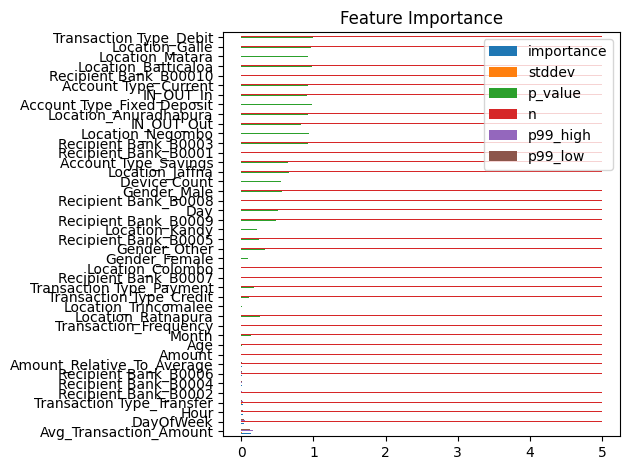

In [21]:
# Feature importance
feature_importance = predictor.feature_importance(test_data)
plt.figure(figsize=(12, 8))
feature_importance.plot(kind='barh')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()



In [22]:
# Leaderboard of models
leaderboard = predictor.leaderboard()
print("\nModel Leaderboard:")
print(leaderboard)



Model Leaderboard:
                      model  score_val eval_metric  pred_time_val    fit_time  \
0       WeightedEnsemble_L2   0.984258     roc_auc       3.824232  127.882999   
1           CatBoost_BAG_L1   0.984255     roc_auc       0.152801   70.284483   
2           LightGBM_BAG_L1   0.983909     roc_auc       0.682366   32.418333   
3         LightGBMXT_BAG_L1   0.983671     roc_auc       2.818206   48.273119   
4            XGBoost_BAG_L1   0.982904     roc_auc       0.348080   31.724070   
5   RandomForestEntr_BAG_L1   0.982055     roc_auc       2.385137   19.956547   
6   RandomForestGini_BAG_L1   0.981698     roc_auc       3.306948   21.787181   
7    NeuralNetFastAI_BAG_L1   0.981667     roc_auc       2.003813  158.012779   
8     ExtraTreesEntr_BAG_L1   0.973273     roc_auc       2.626175   14.210465   
9     ExtraTreesGini_BAG_L1   0.972883     roc_auc       2.750718   13.931935   
10    KNeighborsDist_BAG_L1   0.795832     roc_auc       0.883381    0.296720   
11    KN

In [26]:
# Make predictions
predictions = predictor.predict(test_data)
pred_probs = predictor.predict_proba(test_data)


In [27]:
# Create a DataFrame with actual and predicted values
results_df = test_data[['Fraud']].copy()
results_df['Predicted_Fraud'] = predictions


In [28]:
# Handle prediction probabilities based on their structure
if isinstance(pred_probs, pd.DataFrame):
    # If pred_probs is already a DataFrame, it likely contains probabilities for all classes
    fraud_prob_col = pred_probs.columns[pred_probs.columns.isin([1, '1', True, 'True', 'fraud', 'Fraud'])][0]
    results_df['Fraud_Probability'] = pred_probs[fraud_prob_col]
elif isinstance(pred_probs, np.ndarray):
    # If pred_probs is a numpy array, check its shape
    if pred_probs.ndim == 2 and pred_probs.shape[1] == 2:
        results_df['Fraud_Probability'] = pred_probs[:, 1]
    elif pred_probs.ndim == 1:
        results_df['Fraud_Probability'] = pred_probs
    else:
        raise ValueError("Unexpected shape for pred_probs array")
else:
    raise TypeError("Unexpected type for pred_probs")


In [29]:
# Display a sample of actual vs predicted results
print("\nSample of Actual vs Predicted Results:")
print(results_df.sample(n=10, random_state=42))


Sample of Actual vs Predicted Results:
       Fraud  Predicted_Fraud  Fraud_Probability
86525      0                0           0.000428
4024       0                0           0.000430
4731       0                0           0.001944
46016      0                0           0.002309
46674      0                0           0.000429
76728      0                0           0.000532
16434      0                0           0.000428
63758      0                0           0.146000
42976      0                0           0.118025
96591      0                0           0.201125


In [30]:
results_df.head()

,Fraud,Predicted_Fraud,Fraud_Probability
75721,0,1,0.679292
80184,0,0,0.000434
19864,0,0,0.000428
76699,0,0,0.000428
92991,0,0,0.000428


from matplotlib import pyplot as plt
_df_0['Predicted_Fraud'].plot(kind='hist', bins=20, title='Predicted_Fraud')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Fraud_Probability'].plot(kind='hist', bins=20, title='Fraud_Probability')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Predicted_Fraud', y='Fraud_Probability', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Fraud']
  ys = series['Predicted_Fraud']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Fraud', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Fraud')
_ = plt.ylabel('Predicted_Fraud')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Fraud']
  ys = series['Fraud_Probability']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Fraud', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Fraud')
_ = plt.ylabel('Fraud_Probability')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Fraud']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Fraud'}, axis=1)
              .sort_values('Fraud', ascending=True))
  xs = counted['Fraud']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('Fraud', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Fraud')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_6['Predicted_Fraud'].plot(kind='line', figsize=(8, 4), title='Predicted_Fraud')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Fraud_Probability'].plot(kind='line', figsize=(8, 4), title='Fraud_Probability')
plt.gca().spines[['top', 'right']].set_visible(False)

In [32]:
 #Calculate and display some additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(results_df['Fraud'], results_df['Predicted_Fraud'])
precision = precision_score(results_df['Fraud'], results_df['Predicted_Fraud'])
recall = recall_score(results_df['Fraud'], results_df['Predicted_Fraud'])
f1 = f1_score(results_df['Fraud'], results_df['Predicted_Fraud'])

print("\nAdditional Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Additional Metrics:
Accuracy: 0.9703
Precision: 0.7305
Recall: 0.6112
F1 Score: 0.6655


In [ ]:
# save the model
predictor.save('autogluon_fraud_model')
